# Algotrading prototyping notebook

### Important info

Alpha Vantage API key: DK3F3HB19R3IX4C3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# only run this cell if you want to (refresh) download new data
from alpha_vantage.foreignexchange import ForeignExchange
fx = ForeignExchange(key='YOUR_API_KEY', output_format='pandas')
eurusd, meta = fx.get_currency_exchange_daily(from_symbol='EUR', to_symbol='USD', outputsize='full')
eurusd.to_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv')

In [2]:
# Load the CSV into a DataFrame
eurusd = pd.read_csv('/Users/danieltompkins/Documents/Algotrading_project/Data/EURUSD_180525.csv', index_col=0, parse_dates=True)

# Optional: rename columns for simplicity
eurusd.columns = ['open', 'high', 'low', 'close']


# Optional: sort ascending (older dates first)
eurusd = eurusd.sort_index()

In [3]:
eurusd.head()

,open,high,low,close
date,,,,
2006-03-17,1.2182,1.2207,1.2139,1.2195
2006-03-20,1.2168,1.2196,1.2147,1.2165
2006-03-21,1.2154,1.2171,1.2074,1.2092
2006-03-22,1.2094,1.2114,1.2062,1.2074
2006-03-23,1.2075,1.2081,1.1953,1.1967


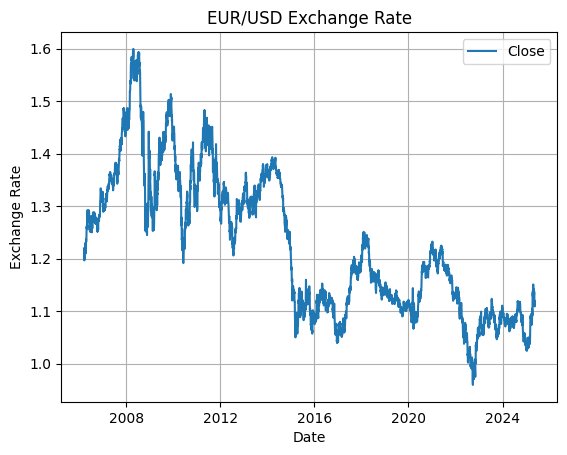

In [4]:
plt.plot(eurusd['close'], label='Close')
plt.title('EUR/USD Exchange Rate')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid()
plt.show()

In [21]:
def generate_signals(df, window=20, num_std=2):
    """
    Generate trading signals based on a Bollinger Band mean reversion strategy.

    Parameters:
    ----------
    df : pandas.DataFrame
        DataFrame containing at least a 'close' column.
    window : int
        Rolling window size for SMA and standard deviation.
    num_std : float
        Number of standard deviations for upper and lower Bollinger Bands.

    Returns:
    -------
    df : pandas.DataFrame
        DataFrame with added columns: 'sma', 'upper_band', 'lower_band',
        'signal', 'exit', and 'position'.
    """
    df = df.copy()

    # Calculate Bollinger Bands
    df['sma'] = df['close'].rolling(window=window).mean()
    df['std'] = df['close'].rolling(window=window).std()
    df['upper_band'] = df['sma'] + num_std * df['std']
    df['lower_band'] = df['sma'] - num_std * df['std']

    # Initialize columns
    df['signal'] = 0
    df['exit'] = 0
    df['position'] = 0

    # Define entry conditions
    buy_entry = df['close'] < df['lower_band']
    sell_entry = df['close'] > df['upper_band']

    # Simulate trade state
    in_trade = 0
    position = []

    for i in range(len(df)):
        price = df['close'].iloc[i]
        sma = df['sma'].iloc[i]
        prev_price = df['close'].shift(1).iloc[i]
        prev_sma = df['sma'].shift(1).iloc[i]

        # ENTRY
        if in_trade == 0:
            if buy_entry.iloc[i]:
                df.at[df.index[i], 'signal'] = 1
                in_trade = 1
            elif sell_entry.iloc[i]:
                df.at[df.index[i], 'signal'] = -1
                in_trade = -1

        # EXIT
        elif in_trade == 1 and price > sma and prev_price <= prev_sma:
            df.at[df.index[i], 'exit'] = 1
            in_trade = 0
        elif in_trade == -1 and price < sma and prev_price >= prev_sma:
            df.at[df.index[i], 'exit'] = 1
            in_trade = 0

        position.append(in_trade)

    df['position'] = position

    return df


In [25]:
def plot_signals_over_period(df, start=None, end=None, rows=None):
    """
    Plot Bollinger Band trading signals (buy, sell, exit) over a selected time period.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain 'close', 'sma', 'upper_band', 'lower_band', 'signal', and 'exit'.
    start : int, str, or datetime (optional)
        Starting index or date for the subset.
    end : int, str, or datetime (optional)
        Ending index or date for the subset.
    rows : int (optional)
        Number of rows from the end to include (overrides start/end if provided).
    """
    if rows is not None:
        subset = df.iloc[-rows:]
    elif start is not None and end is not None:
        subset = df.loc[start:end] if isinstance(start, str) or isinstance(start, pd.Timestamp) else df.iloc[start:end]
    else:
        raise ValueError("You must provide either `rows` or both `start` and `end`.")

    plt.figure(figsize=(14, 6))

    # Plot price + Bollinger Bands
    plt.plot(subset.index, subset['close'], label='Close Price', color='blue', linewidth=1.5)
    plt.plot(subset.index, subset['sma'], label='SMA', linestyle='--', color='orange')
    plt.plot(subset.index, subset['upper_band'], label='Upper Band', linestyle='--', color='green')
    plt.plot(subset.index, subset['lower_band'], label='Lower Band', linestyle='--', color='red')
    plt.fill_between(subset.index, subset['lower_band'], subset['upper_band'], color='grey', alpha=0.1)

    # Plot signals
    buy_signals = subset[subset['signal'] == 1]
    plt.scatter(buy_signals.index, buy_signals['close'], label='Buy', marker='^', color='green', s=100, zorder=3)

    sell_signals = subset[subset['signal'] == -1]
    plt.scatter(sell_signals.index, sell_signals['close'], label='Sell', marker='v', color='red', s=100, zorder=3)

    exit_signals = subset[subset['exit'] == 1]
    plt.scatter(exit_signals.index, exit_signals['close'], label='Exit', marker='o', color='gray', s=60, zorder=3)

    plt.title('EURUSD — Bollinger Band Strategy: Buy, Sell, Exit Signals')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [22]:
def run_backtest(df, fee=0.0):
    """
    Run a vectorized backtest on a signal-enhanced DataFrame.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain a 'close' column and a 'position' column (1, -1, 0).
    fee : float
        Transaction cost per position change (in decimal form, e.g., 0.0002 for 2bps).

    Returns:
    -------
    dict
        Contains updated DataFrame and performance metrics.
    """
    df = df.copy()
    
    # Step 1: Basic returns
    df['returns'] = df['close'].pct_change()

    # Step 2: Strategy returns
    df['strategy_returns'] = df['position'].shift(1) * df['returns']
    df['strategy_returns'] -= fee * df['position'].diff().abs().fillna(0)

    # Step 3: Cumulative returns
    df['cumulative_market'] = (1 + df['returns']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_returns']).cumprod()

    # Step 4: Metrics
    strategy_returns = df['strategy_returns'].dropna()
    sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252) if strategy_returns.std() > 0 else 0
    max_drawdown = (df['cumulative_strategy'] / df['cumulative_strategy'].cummax() - 1).min()
    final_return = df['cumulative_strategy'].iloc[-1]

    return {
        'df': df,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown,
        'final_return': final_return
    }



In [23]:
def plot_equity_curve(df):
    """
    Plot the equity curve for strategy and market.

    Parameters:
    ----------
    df : pandas.DataFrame
        Must contain 'cumulative_market' and 'cumulative_strategy' columns.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df['cumulative_market'], label='Market', color='grey', linestyle='--')
    plt.plot(df['cumulative_strategy'], label='Strategy', color='blue')
    plt.title('EURUSD Bollinger Band Strategy vs Market')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


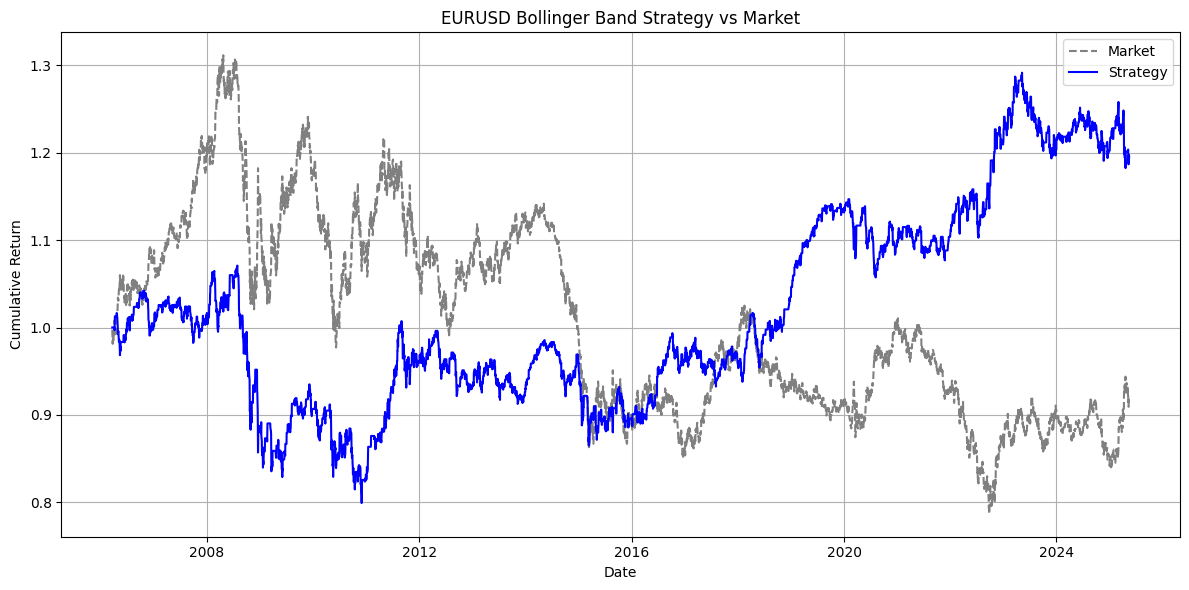

Sharpe Ratio: 0.16
Max Drawdown: -25.39%
Final Return: 1.19x


In [28]:
signals_df = generate_signals(eurusd, 10, 1.5)
results = run_backtest(signals_df)
plot_equity_curve(results['df'])

print(f"Sharpe Ratio: {results['sharpe']:.2f}")
print(f"Max Drawdown: {results['max_drawdown']:.2%}")
print(f"Final Return: {results['final_return']:.2f}x")